# ZMYM3
[X-linked intellectual developmental disorder-112 (XLID112)](https://omim.org/entry/301111) is caused by hemizygous or heterozygous mutation in the ZMYM3 gene.

In [1]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2024-08-13')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.9.1.dev0


### ZMYM3
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for ZMYM3.

In [2]:
gene_symbol = 'ZMYM3'
mane_tx_id = 'NM_201599.3'
mane_protein_id = 'NP_963893.1' # zinc finger MYM-type protein 3 isoform 1 [Homo sapiens]

In [3]:
from ppktstore.registry import configure_phenopacket_registry
phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.21") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
print(f'Loaded {len(phenopackets)} phenopackets')

from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets
cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
validation.summarize()

Loaded 29 phenopackets
Individuals Processed: 100%|██████████| 29/29 [00:44<00:00,  1.52s/individuals]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

n,HPO Term
26,Delayed speech and language development
18,Motor delay
17,Intellectual disability
15,Autistic behavior
6,Hypospadias
5,Short stature
5,Atypical behavior
5,Microcephaly
4,Gastroesophageal reflux
3,Cupped ear


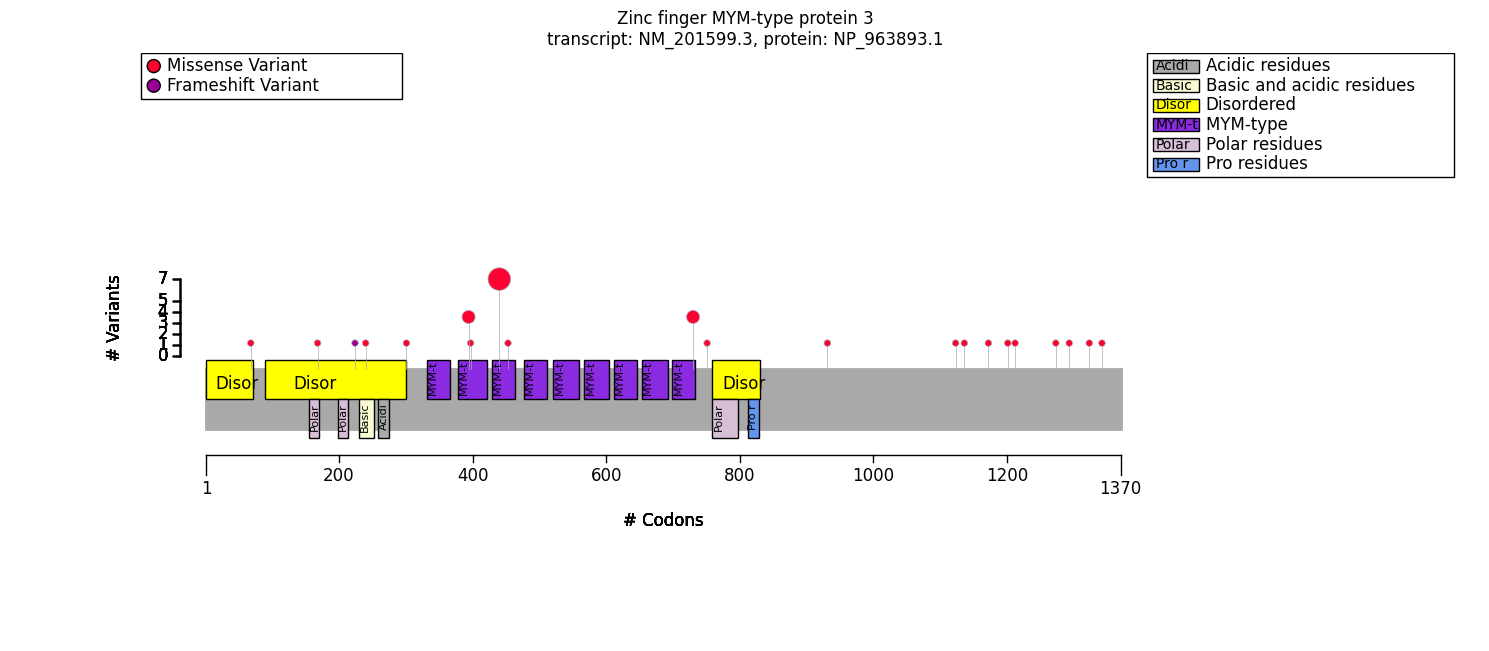

In [5]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)


zmym3_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
zmym3_fig.tight_layout()

# Genotype-Phenotype Correlation (GPC) Analysis

In [7]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
pheno_predicates = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [8]:
from gpsea.model.genome import Region

from gpsea.analysis.predicate import protein_region
from gpsea.analysis.clf import monoallelic_classifier

n_term = protein_region(region=Region(1, 600), tx_id=mane_tx_id)
gt_predicate = monoallelic_classifier(
    a_predicate=n_term,
    b_predicate=~n_term,
    a_label="N term",
    b_label="other"
)
nterm_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=gt_predicate,
    pheno_clfs=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(nterm_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,2
HMF03,Skipping term because of a child term with the same individual counts,4
HMF08,Skipping general term,53
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,95


In [9]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=nterm_result)

Allele group                                       N term          other  \
                                                    Count Percent  Count   
Motor delay [HP:0001270]                            10/13     77%   8/13   
Autistic behavior [HP:0000729]                       9/13     69%   6/11   
Delayed speech and language development [HP:000...  13/13    100%  13/13   
Neurodevelopmental delay [HP:0012758]               13/13    100%  13/13   
Neurodevelopmental abnormality [HP:0012759]         16/16    100%  13/13   
Abnormal communication [HP:0034434]                 13/13    100%  13/13   
Intellectual disability [HP:0001249]                11/13     85%   9/10   
Diagnostic behavioral phenotype [HP:0025783]         9/11     82%    6/7   
Atypical behavior [HP:0000708]                      12/14     86%  10/11   

Allele group                                                                   \
                                                   Percent Corrected p values   
Motor delay [HP:0001270]                               62%                1.0   
Autistic behavior [HP:0000729]                         55%                1.0   
Delayed speech and language development [HP:000...    100%                1.0   
Neurodevelopmental delay [HP:0012758]                 100%                1.0   
Neurodevelopmental abnormality [HP:0012759]           100%                1.0   
Abnormal communication [HP:0034434]                   100%                1.0   
Intellectual disability [HP:0001249]                   90%                1.0   
Diagnostic behavioral phenotype [HP:0025783]           86%                1.0   
Atypical behavior [HP:0000708]                         91%                1.0   

Allele group                                                  
                                                    p values  
Motor delay [HP:0001270]                            0.672769  
Autistic behavior [HP:0000729]                      0.675175  
Delayed speech and language development [HP:000...  1.000000  
Neurodevelopmental delay [HP:0012758]               1.000000  
Neurodevelopmental abnormality [HP:0012759]         1.000000  
Abnormal communication [HP:0034434]                 1.000000  
Intellectual disability [HP:0001249]                1.000000  
Diagnostic behavioral phenotype [HP:0025783]        1.000000  
Atypical behavior [HP:0000708]                      1.000000

In [10]:
from gpsea.analysis.predicate import variant_key

r441w = variant_key("X_71249610_71249610_G_A") #c.1321C>T	p.Arg441Trp
r441q = variant_key("X_71249609_71249609_C_T") #c.1322G>A	p.Arg441Gln	
r441 = r441w | r441q

is_r441 = monoallelic_classifier(
    a_predicate=r441,
    b_predicate=~r441,
    a_label="R441",
    b_label="other"
)
r441_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=is_r441,
    pheno_clfs=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=r441_result)

Allele group                                        R441          other  \
                                                   Count Percent  Count   
Autistic behavior [HP:0000729]                       4/4    100%  11/20   
Intellectual disability [HP:0001249]                 7/7    100%  13/16   
Atypical behavior [HP:0000708]                       6/6    100%  16/19   
Delayed speech and language development [HP:000...   4/4    100%  22/22   
Neurodevelopmental delay [HP:0012758]                4/4    100%  22/22   
Neurodevelopmental abnormality [HP:0012759]          7/7    100%  22/22   
Abnormal communication [HP:0034434]                  4/4    100%  22/22   
Motor delay [HP:0001270]                             3/4     75%  15/22   
Diagnostic behavioral phenotype [HP:0025783]         4/4    100%  11/14   

Allele group                                                                   \
                                                   Percent Corrected p values   
Autistic behavior [HP:0000729]                         55%                1.0   
Intellectual disability [HP:0001249]                   81%                1.0   
Atypical behavior [HP:0000708]                         84%                1.0   
Delayed speech and language development [HP:000...    100%                1.0   
Neurodevelopmental delay [HP:0012758]                 100%                1.0   
Neurodevelopmental abnormality [HP:0012759]           100%                1.0   
Abnormal communication [HP:0034434]                   100%                1.0   
Motor delay [HP:0001270]                               68%                1.0   
Diagnostic behavioral phenotype [HP:0025783]           79%                1.0   

Allele group                                                  
                                                    p values  
Autistic behavior [HP:0000729]                      0.258893  
Intellectual disability [HP:0001249]                0.525692  
Atypical behavior [HP:0000708]                      0.553913  
Delayed speech and language development [HP:000...  1.000000  
Neurodevelopmental delay [HP:0012758]               1.000000  
Neurodevelopmental abnormality [HP:0012759]         1.000000  
Abnormal communication [HP:0034434]                 1.000000  
Motor delay [HP:0001270]                            1.000000  
Diagnostic behavioral phenotype [HP:0025783]        1.000000

In [10]:
# Summary

In [11]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary

f_results = (
    GPAnalysisResultSummary.from_mono(
        result=nterm_result,
    ),
    GPAnalysisResultSummary.from_mono(
        result=r441_result,
    ),
)

caption = "No statistically significant results identified."
report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=f_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [12]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

ValueError: The 'gpseacs' package was not installed in a way that PackageLoader understands.

In [12]:
summarizer.process_latex(report=report, protein_fig=zmym3_fig)

Figure saved to ../../supplement/img/ZMYM3_protein_diagram-draft.pdf
Output to ../../supplement/tex/ZMYM3_summary_draft.tex
